[2018-01-02 00:00:00.000000] INFO: user_log: init


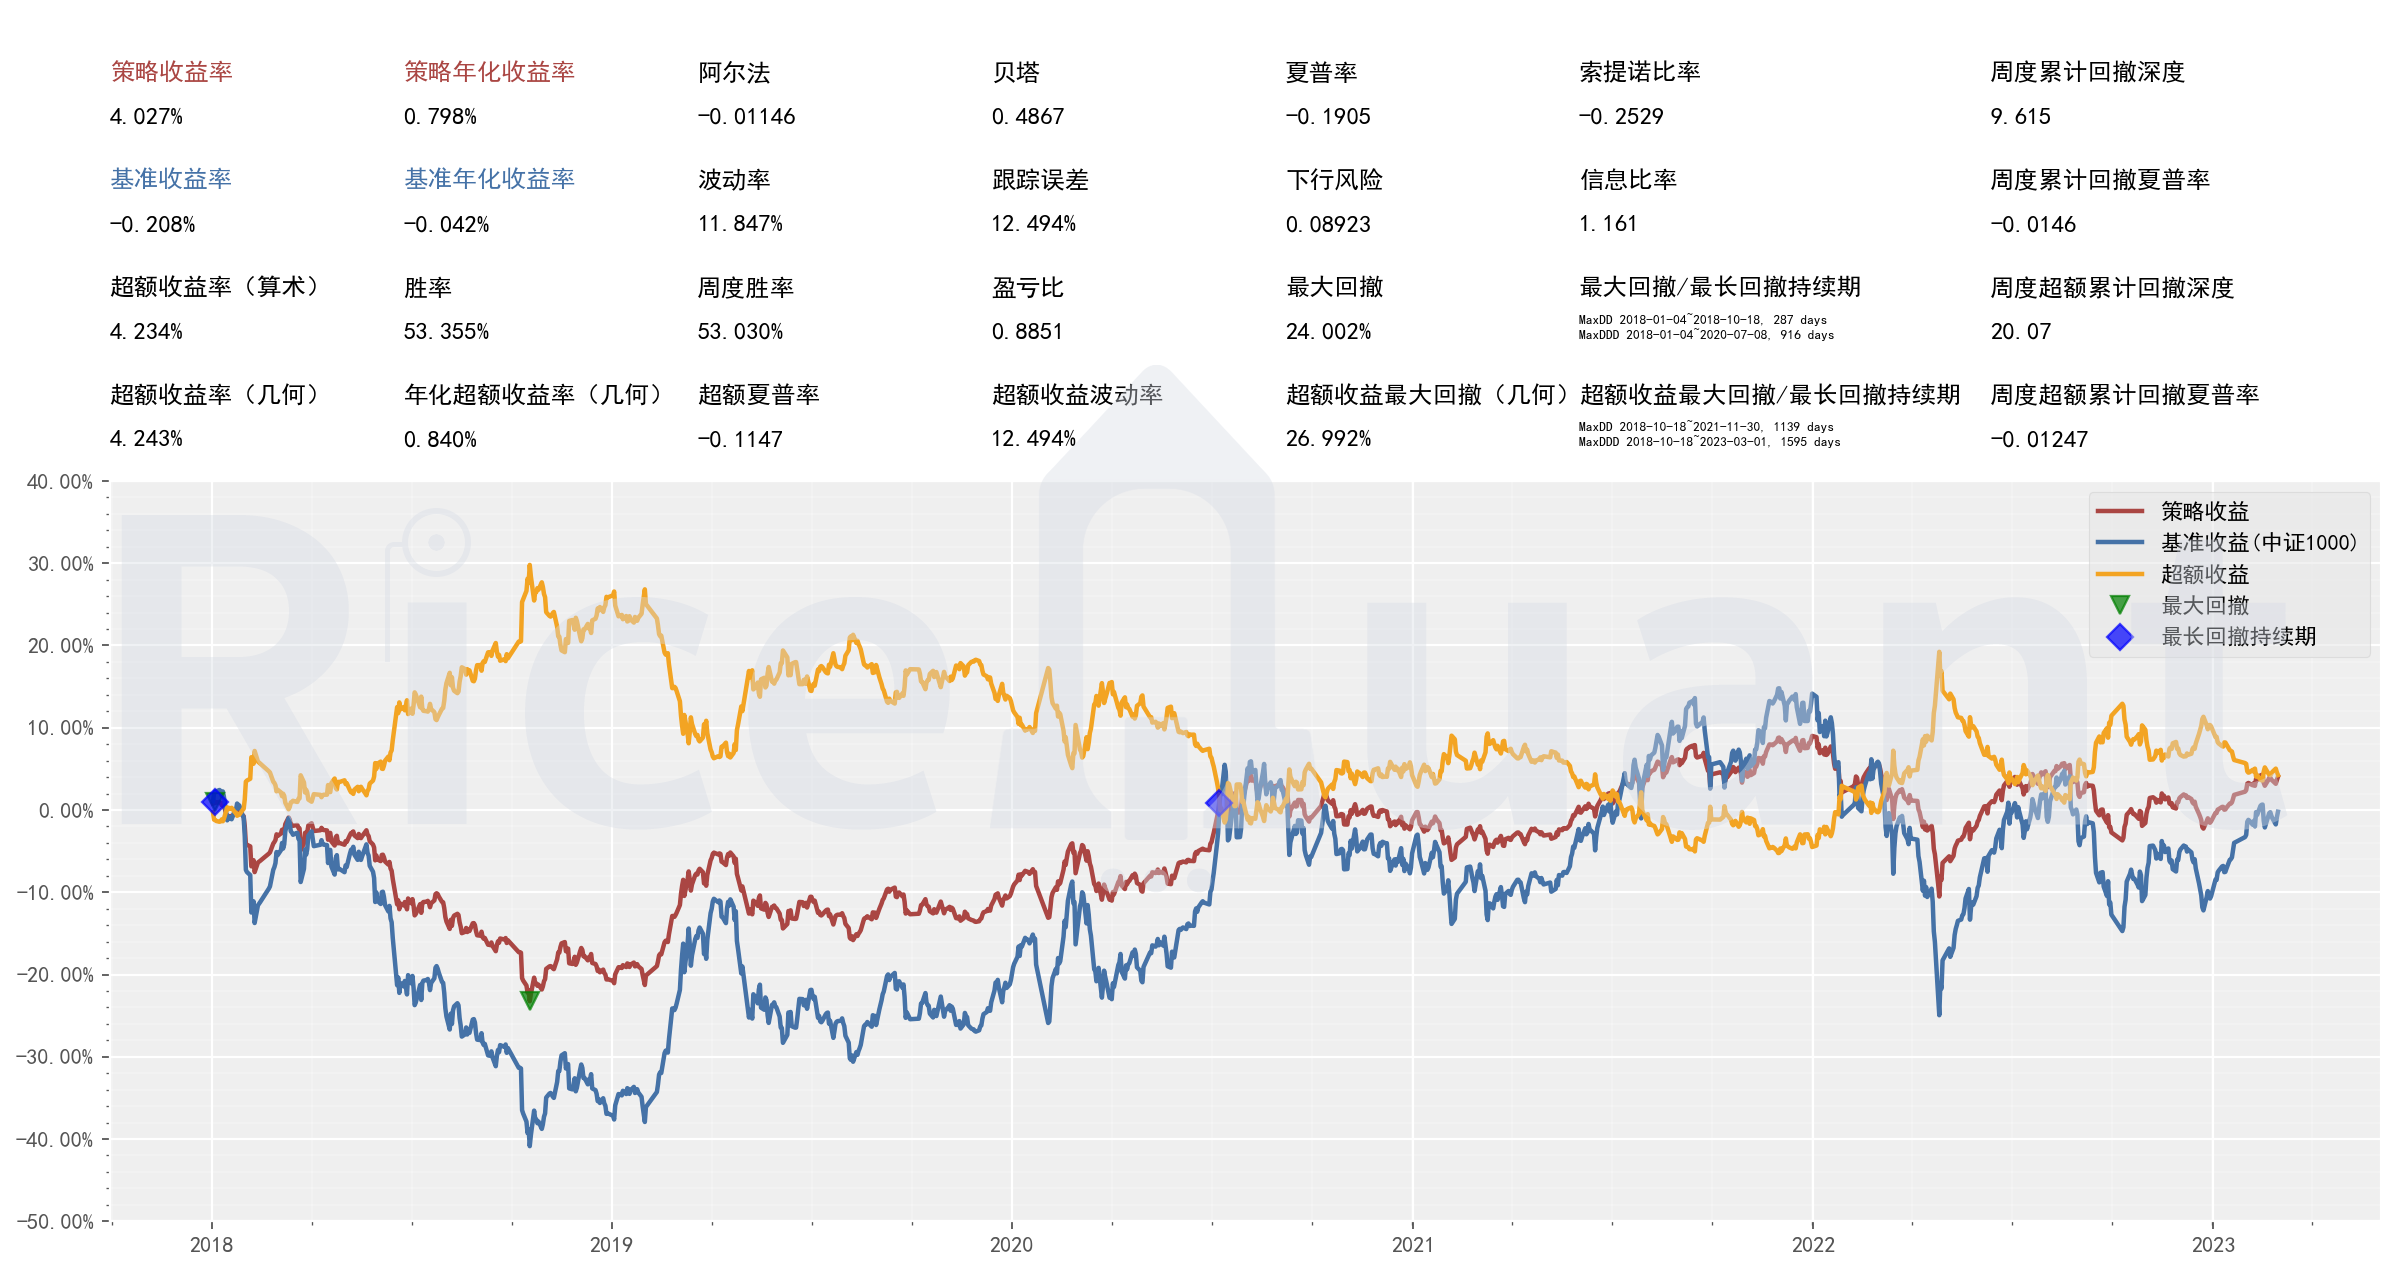

{'strategy_name': 'strategy', 'start_date': '2018-01-02', 'end_date': '2023-03-01', 'strategy_file': 'strategy.py', 'run_type': 'BACKTEST', 'starting_cash': 'STOCK:10000000.0', 'STOCK': 10000000.0, 'benchmark': '000852.XSHG', 'benchmark_symbol': '中证1000', 'alpha': -0.011459983343116781, 'beta': 0.48666524254939453, 'sharpe': -0.1904937628662684, 'excess_sharpe': -0.11466102212041937, 'information_ratio': 1.1609064110284866, 'downside_risk': 0.08922737717565478, 'tracking_error': 0.12494149926005015, 'sortino': -0.2529279269075689, 'volatility': 0.11847157194475437, 'excess_volatility': 0.12494149926005015, 'max_drawdown': 0.2400240711684432, 'excess_max_drawdown': 0.2699189093962675, 'excess_returns': 0.04243264679410563, 'excess_annual_returns': 0.008399601461557715, 'var': 0.012347320154269679, 'win_rate': 0.5335463258785943, 'excess_win_rate': 0.4672523961661342, 'excess_cum_returns': 0.04234448358039591, 'profit_loss_rate': 0.885072348064198, 'total_value': 10402667.622886367, 'cas

In [6]:
# -*- coding: utf-8 -*-
import sys
import os
import time
import random
sys.path.append("/data/code/finhack/")
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)
import pickle
from rqalpha.apis import *
from rqalpha import run_func
import time
import math
from astock.indexHelper import indexHelper

model_hash="4117bab4ed82a9c0ce2c20a93b48bfe2"
n=2
benchmark="000852.XSHG"

# if len(sys.argv)>=2:
#     model_hash=sys.argv[1]
# if len(sys.argv)>=3:
#     n=int(sys.argv[2])
# if len(sys.argv)>=4:
#     benchmark=sys.argv[3]




def on_trade_handler(context,event):
    trade = event.trade
    order = event.order
    account = event.account
    #logger.info("*" * 10 + "Trade Handler" + "*" * 10)
    #logger.info(trade)
    
    code=order.order_book_id.replace('XSHG','SH') 
    code=code.replace('XSHE','SZ')
    now_date=context.now.strftime("%Y%m%d")
    vol=str(order.filled_quantity)
    price=str(order.avg_price)
    side=""
    if order.side==SIDE.BUY:
      side="买入"
    else:
      side="卖出"
    
    buy_str="%s %s %s%s股，当前价格%s [trade]" %(now_date,code,side,vol,price)
    
    logger.info(buy_str)
    #logger.info(account)


def init(context):
    
    pred_path="/data/code/finhack/data/preds/lgb_model_%s_pred.pkl" % model_hash
    pred=pickle.load(open(pred_path, "rb"))  
    pred=pred.set_index(['trade_date','ts_code'])
    logger.info("init")
    context.pred = pred
    
    context.n=n
    context.benchmark=benchmark
    #subscribe_event(EVENT.TRADE,on_trade_handler)
    


def before_trading(context):
    pass




def handle_bar(context, bar_dict):
    #print(context.now)
    pass   # order_percent并且传入1代表买入该股票并且使其占有投资组合的100%
    #order_percent(context.s1, 1)
 
 
def open_auction(context, bar_dict):
    #now=time.strftime("%Y%m%d", time.localtime(context.now))
    now_date=context.now.strftime("%Y%m%d")
    try:
      bench_code=context.benchmark.replace('XSHG','SH') 
      bench_code=bench_code.replace('XSHE','SZ')
      idx_weight=indexHelper.get_index_weights(bench_code,now_date)
      idx_weight=idx_weight.set_index('ts_code',drop=True)
      pred=context.pred.loc[now_date]
      pred=pred.sort_values(by='pred',ascending=False, inplace=False) 
      pred=pred[~pred.index.duplicated()]
    except Exception as e:
      print(str(e))
      return
        
    sr=pred    
    for ts_code,row in sr.iterrows():
        if ts_code in idx_weight.index.values:
            idx_weight.loc[ts_code,'weight']=float(idx_weight.loc[ts_code]['weight'])*math.pow(row['pred'],context.n)
    
    
    for pos in get_positions():
      code=pos.order_book_id
      code=code.replace('XSHG','SH') 
      code=code.replace('XSHE','SZ')
      if code not in idx_weight.index.values:
        code=code.replace('SH','XSHG') 
        code=code.replace('SZ','XSHE') 
        order_target_percent(code, 0)
      
    cash=context.portfolio.cash
      
    for code,row in idx_weight.iterrows():
        weight=float(row['weight'])#*0.01*1.05
        #print(weight)
        code=code.replace('SH','XSHG') 
        code=code.replace('SZ','XSHE') 
        
 
        #order_target_percent(code, weight)
        
        
        
        pos_cash=cash*weight*0.01*1.05
                
        if pos_cash<100:
                break
              
        #print(pos_cash)

        order_target_value(code, pos_cash)
        


config = {
  "base": {
    "start_date": "2018-01-01",
    "end_date": "2023-03-17",
    "accounts": {
      "stock": 10000000
    }
  },
  "extra": {
      "log_level":"error"
   # "log_level": "info",#verbose | code:info | warning | error
  },
  "mod": {
    "sys_progress": {
            "enabled": True,
            "show": True
    },
    "sys_analyser": {
      "enabled": True,
      "plot": True,
      "output_file": "/data/code/finhack/data/backtest/"+model_hash+'_'+str(n)+"_"+benchmark+".pkl",
      "benchmark":benchmark
      
    }
  }
}

# 您可以指定您要传递的参数
run_func(init=init, before_trading=before_trading,open_auction=open_auction, handle_bar=handle_bar, config=config)
# 如果你的函数命名是按照 API 规范来，则可以直接按照以下方式来运行
# run_func(**globals())



result_dict = pickle.load(open("/data/code/finhack/data/backtest/"+model_hash+'_'+str(n)+"_"+benchmark+".pkl", "rb"))   # 从输出pickle中读取数据

print(result_dict["summary"])